# task-perturb-multiomics-grn
## Post process
### by Jalil Nourisa

In [2]:
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt

import os
import numpy as np
from local_utils import plots

work_dir = '../output/'
cell_types = ['B cells','T cells','Myeloid cells','NK cells']

# Baseline GRNs

In [ ]:
def create_negative_control(tf_n: int=800, sparsity: float=.98):
    import pandas as pd 
    import os
    import numpy as np
    df_train = pd.read_csv(f'../resources/df_train/df_train.csv')

    genes_n = df_train.columns.shape[0]
    X_random = np.random.choice([0, -1, 1], size=(genes_n, tf_n), p=[sparsity, (1-sparsity)/2, (1-sparsity)/2])
    row_names = df_train.columns
    col_names = [f'TF_{i}' for i in range(tf_n)]
    grn_random = pd.DataFrame(X_random, index=row_names, columns=col_names)
    grn_random.reset_index(inplace=True)
    grn_random = pd.melt(grn_random, id_vars=['index'], var_name='TF', value_name='weight')
    grn_random.columns = ['target', 'source', 'weight']
    grn_random = grn_random[['source', 'target', 'weight']]
    grn_random = grn_random[grn_random.weight!=0].reset_index(drop=True)

    print(grn_random.shape)

    grn_random.to_csv(f'../output/benchmarking/baseline_models/negative_control.csv')

create_negative_control()

In [ ]:
tfs_list = np.loadtxt(f'../output/utoronto_human_tfs_v_1.01.txt', dtype=str)
df_train = pd.read_csv(f'../resources/df_train/df_train.csv').set_index(['sm_name','cell_type','plate_name','row'])

In [ ]:
gene_names = df_train.columns
tfs_list =  np.asarray([gene for gene in tfs_list if gene in df_train.columns])
tf_idx = np.asarray([idx for idx, gene in enumerate(df_train.columns) if gene in tfs_list])

In [ ]:
import portia as pt
dataset = pt.GeneExpressionDataset()
for exp_id, data in enumerate(df_train.values):
    dataset.add(pt.Experiment(exp_id, data))
M_bar, S = pt.run(dataset, tf_idx=tf_idx, method='fast', return_sign=True)

def format_grn(scores, S, gene_names):
    tfs = []
    targets = []
    weights = []
    for row_i in range(len(scores)):
        for col_i in range(len(scores[0])):
            score = scores[row_i][col_i]
            if score == 0:
                continue
            s = S[row_i][col_i]
            tf = gene_names[row_i]
            gene = gene_names[col_i]

            tfs.append(tf)
            targets.append(gene)
            weights.append(score*s)

    return pd.DataFrame({'source':tfs, 'target':targets, 'weight':weights})

positive_control = format_grn(M_bar, S, gene_names)

positive_control

positive_control_f = positive_control[positive_control.index.isin(positive_control.weight.abs().sort_values()[-200000:,].index)].reset_index()

positive_control_f.to_csv(f'../output/benchmarking/baseline_models/positive_control.csv')

# Postporcess GRNs

In [ ]:
os.makedirs(f'{work_dir}/benchmarking/grn_models/', exist_ok=True)
os.makedirs(f'{work_dir}/benchmarking/peak_gene_models/', exist_ok=True)

## Subset GRNs

### Celloracle

In [59]:
grn_stack =  []
celloracle_grns_dict = {}
for i_plot, cell_type in enumerate(cell_types):
    grn = pd.read_csv(f'{work_dir}/infer/celloracle/grn/grn_{cell_type}.csv')
    grn = grn[~(grn.coef_abs==0)] # remove those with 0 coeff
    celloracle_grns_dict[cell_type] = grn

B cells links: 63958  TFs:  493  target:  6601
T cells links: 47886  TFs:  415  target:  6834
Myeloid cells links: 48138  TFs:  463  target:  6206
NK cells links: 58790  TFs:  479  target:  6126


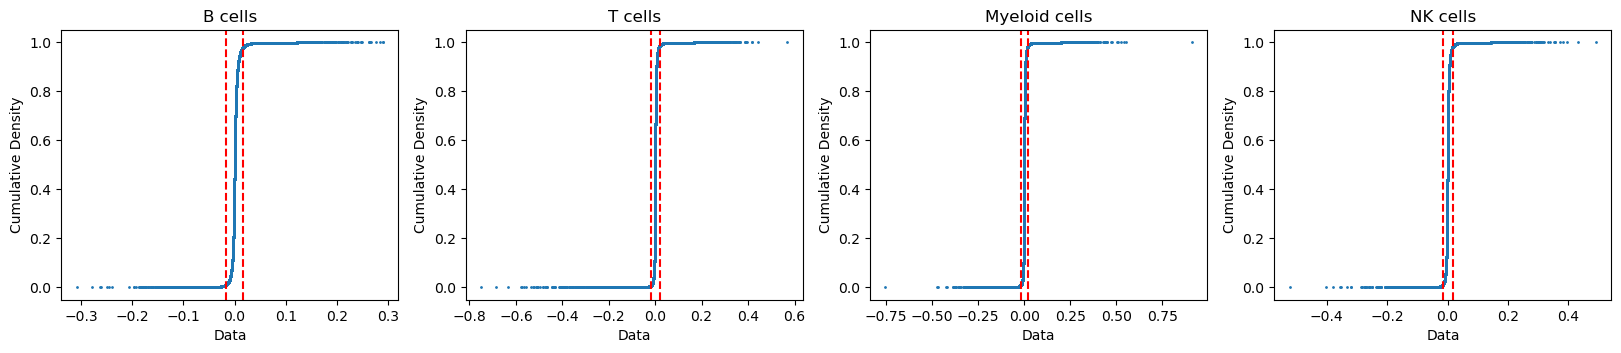

In [60]:
fig, axes = plt.subplots(1, 4, figsize=(20, 3.5))
for i_plot, (cell_type, grn) in enumerate(celloracle_grns_dict.items()): 
    ax = axes[i_plot]
    plots.plot_cumulative_density(grn.coef_mean, ax=ax, title=cell_type)
    z_scores = (grn.coef_abs - grn.coef_abs.mean())/grn.coef_abs.std()
    mask = z_scores > 2
    grn = grn.loc[mask, :]

    grn = grn[['source', 'target', 'coef_mean']]

    grn.columns = ['source', 'target', 'weight']

    print(cell_type, 'links:', len(grn), ' TFs: ', grn.source.unique().shape[0], ' target: ', grn.target.unique().shape[0],)
    
    min_weight = grn.weight.abs().min()
#     # grn['link'] = grn.source + '_' + grn.target
    ax.axvline(np.mean(min_weight), color='r', linestyle='--', linewidth=1.5)
    ax.axvline(-np.mean(min_weight), color='r', linestyle='--', linewidth=1.5)
    
    grn['cell_type'] = cell_type
    grn_stack.append(grn)
celloracle_grn = pd.concat(grn_stack).reset_index(drop=True)


In [61]:
celloracle_grn.weight.min()

-0.75457895

In [62]:
celloracle_grn.to_csv(f'{work_dir}/infer/celloracle/grn/celloracle_grn_cell_type.csv')

In [ ]:
celloracle_grn.groupby(['source', 'target'])['weight'].apply(np.mean).to_frame().reset_index().to_csv(f'../output/benchmark/grn_models/celloracle.csv')

### Scenicplus

In [63]:
import pandas as pd 
scenicplus_grn = pd.read_csv(f'{work_dir}/infer/scenicplus/grn/scenicplus_grn.csv')

### FigR

In [64]:
figr_grn = pd.read_csv(f'{work_dir}/infer/figr/grn/figr_grn.csv')

### Granie 

In [65]:
grn_granie = pd.read_csv(f'{work_dir}/infer/granie/grn/granie_grn.csv')

### Ananse

In [66]:
# ananse_grns = {}
# for cell_type in cell_types:
#     grn = pd.read_csv(f"{work_dir}/infer/ananse/grn/{cell_type.replace(' ','-')}.tsv", sep='\t')
#     grn[['source', 'target']] = grn['tf_target'].str.split('—', expand=True)
#     ananse_grns[cell_type] = grn

In [67]:
# fig, axes = plt.subplots(1, 4, figsize=(20, 3.5))
# grn_stack = []
# for i_plot, (cell_type, grn) in enumerate(ananse_grns.items()): 
#     grn = grn[grn.target_expression!=0]
#     grn['weight'] = grn[['prob', 'weighted_binding', 'activity']].sum(axis=1)
#     grn = grn[['source','target', 'weight']]
#     ax = axes[i_plot]
#     plots.plot_cumulative_density(grn.weight, ax=ax, title=cell_type)
#     z_scores = (grn.weight - grn.weight.mean())/grn.weight.std()
#     mask = z_scores > 2
#     grn = grn.loc[mask, :]

#     print(cell_type, 'links:', len(grn), ' TFs: ', grn.source.unique().shape[0], ' target: ', grn.target.unique().shape[0],)
    
#     min_weight = grn.weight.abs().min()
# #     # grn['link'] = grn.source + '_' + grn.target
#     ax.axvline(np.mean(min_weight), color='r', linestyle='--', linewidth=1.5)
    
#     grn['cell_type'] = cell_type
#     grn_stack.append(grn)
# ananse_grn = pd.concat(grn_stack).reset_index(drop=True)

In [68]:
# ananse_grn.to_csv(f"{work_dir}/infer/ananse/grn/ananse_grn.csv")

### scGLUE

In [69]:
from ast import literal_eval
import pandas as pd
df = pd.read_csv(
    f"{work_dir}/infer/scglue/pruned_grn.csv", header=None, skiprows=3,
    usecols=[0, 8], names=["TF", "targets"]
)

tfs_list = []
target_list = []
weight_list = []
for i, (tf, targets) in df.iterrows():
    for target, weight in literal_eval(targets):
        tfs_list.append(tf)
        target_list.append(target)
        weight_list.append(weight)
scglue_grn = pd.DataFrame(np.stack([tfs_list, target_list, weight_list], axis=1), columns=['source','target','weight'])
scglue_grn.weight = scglue_grn.weight.astype(float)
scglue_grn = scglue_grn.drop_duplicates().reset_index(drop=True)
scglue_grn

,source,target,weight
0,ABI3,SERF2,0.492266
1,ABI3,HMGN2,1.978421
2,ABI3,PFN1,1.763803
3,ABI3,DRAP1,2.075658
4,ABI3,ACTB,0.504045
...,...,...,...
51562,ZNF667,LINC00638,0.166595
51563,ZNF667,GDF10,0.023349
51564,ZNF667,BCAS4,0.043807
51565,ZNF667,TCL1A,0.018544


In [70]:
scglue_grn.to_csv(f"{work_dir}/infer/scglue/grn/scglue_grn.csv")

## Plot CDF

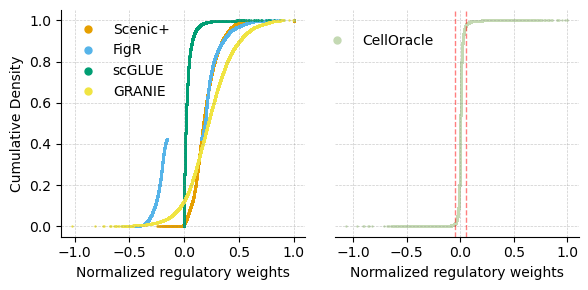

In [71]:
from local_utils import plots
def plot_cumulative_density(data, title='', ax=None, **kwdgs):
    # Step 1: Sort the data
    sorted_data = np.sort(data)

    # Step 2: Compute the cumulative density values
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

    # Step 3: Plot the data
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    else:
        fig = None
    ax.scatter(sorted_data, cdf,  **kwdgs)

    ax.set_ylabel('Cumulative Density')

    # ax.grid(True)
    return fig, ax
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharey=False)
ax = axes[0]
legend_handles = []
for i_plot, (name, grn) in enumerate(zip(['Scenic+','FigR','scGLUE','GRANIE'],[scenicplus_grn, figr_grn, scglue_grn, grn_granie])):
    weights = grn.weight.values
    weights = weights/max(weights)
    color = plots.colors_blind[i_plot]
    plot_cumulative_density(weights, ax=ax, c=color, s=.5)
    legend_handles.append(plt.Line2D([0], [0], linestyle='none', marker='o', markersize=1, label=name, color=color))

# ax.set_yticks([])
# ax.set_xticks([])
ax.legend(handles=legend_handles, loc='upper left', bbox_to_anchor=(0,1), scatterpoints=1, markerscale=5, prop={'size': 10},frameon=False)
ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
ax.set_xlabel('Normalized regulatory weights')
# ax.set_title('title')
ax.spines[['right', 'top']].set_visible(False)

ax=axes[1]
name='CellOracle'
color = plots.colors_cell_type[0]
celloracle_grn_celltype = celloracle_grn[celloracle_grn.cell_type=='B cells'] # we plot only for one cell type
weights = celloracle_grns_dict['B cells'].coef_mean
weights = weights/max(weights)
plot_cumulative_density(weights, ax=ax, c=color, s=.5)
handle = plt.Line2D([0], [0], linestyle='none', marker='o', markersize=1, label=name, color=color)
ax.axvline(.05, color='r', linestyle='--', linewidth=1, alpha=.5)
ax.axvline(-.05, color='r', linestyle='--', linewidth=1, alpha=.5)
ax.set_ylabel('')
ax.set_yticklabels([])
ax.tick_params(axis='y', length=0)
ax.set_xlabel('Normalized regulatory weights')
ax.legend(handles=[handle], loc='upper left', bbox_to_anchor=(-.1,.95), scatterpoints=1, markerscale=5, prop={'size': 10},frameon=False)
ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
ax.spines[['left', 'right', 'top']].set_visible(False)

# ax.set_xlabel('')
# ax.set_xticks([])

plt.tight_layout()

## Copy to one place

In [74]:
grn_model_names = ['figr', 'celloracle', 'granie', 'ananse', 'scglue', 'scenicplus']
for name in grn_model_names:
    grn = pd.read_csv(f'{work_dir}/infer/{name}/grn/{name}_grn.csv', index_col=0)
    if 'cell_type' in grn.columns:
        grn['cell_type'].replace({'agg_type': 'T cells'}, inplace=True)
    
    grn.to_csv(f'{work_dir}/benchmark/grn_models/{name}.csv')
collectRI = pd.read_csv("https://github.com/pablormier/omnipath-static/raw/main/op/collectri-26.09.2023.zip")
collectRI.to_csv(f'{work_dir}/benchmark/grn_models/collectri.csv')

peak_gene_model = ['figr', 'celloracle', 'granie']

for name in peak_gene_model:
    peak_gene = pd.read_csv(f'{work_dir}/infer/{name}/peak_gene.csv', index_col=0)
    peak_gene.columns = ['source','target']
    peak_gene.to_csv(f'{work_dir}/benchmark/peak_gene_models/{name}.csv')

/tmp/ipykernel_1317/2684340407.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  grn['cell_type'].replace({'agg_type': 'T cells'}, inplace=True)


: 